In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np

print(tf.__version__)

2.0.0


In [2]:
vocab_size = 10000# 设置数据中词表的个数
index_from = 3# 词表中索引从3开始起算

imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=vocab_size, index_from= index_from)

In [3]:
word_index = imdb.get_word_index()
print(len(word_index))
# print(word_index)



88584


In [4]:
# 一个映射单词到整数索引的词典
word_index = imdb.get_word_index()
# 保留第一个索引
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '<UNK>') for i in text])


In [5]:
maxlen = 256

train_data = keras.preprocessing.sequence.pad_sequences(
                                                        train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',# pre是前面
                                                        maxlen=maxlen)

test_data = keras.preprocessing.sequence.pad_sequences(
                                                        test_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=maxlen)


In [10]:
# 单层单向循环神经网络
#return_sequences是否返回为下一次的输出，因为只一层rnn，所以false
enbedding_dim = 16
batch_size = 128

single_rnn_model = keras.Sequential()
single_rnn_model.add(keras.layers.Embedding(vocab_size, enbedding_dim,
                                                    input_length=maxlen))
single_rnn_model.add(keras.layers.SimpleRNN(units=64,return_sequences=False))
single_rnn_model.add(keras.layers.Dense(64, activation='relu'))
single_rnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

single_rnn_model.summary()
single_rnn_model.compile(optimizer='adam',#optimizer优化器
              loss='binary_crossentropy',#由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 binary_crossentropy 损失函数。
              metrics=['accuracy'])#准确率（accuracy）结果会返回一个accuracy


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 256, 16)           160000    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                5184      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
Total params: 169,409
Trainable params: 169,409
Non-trainable params: 0
_________________________________________________________________


In [12]:
single_rnn_history = single_rnn_model.fit(train_data,
                                            train_labels,
                                            epochs=5,
                                            batch_size=batch_size,
                                            validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/5
20000/20000 [==============================] - 121s 6ms/sample - loss: 0.6936 - accuracy: 0.5005 - val_loss: 0.6927 - val_accuracy: 0.5002
Epoch 2/5
20000/20000 [==============================] - 116s 6ms/sample - loss: 0.6853 - accuracy: 0.5362 - val_loss: 0.6882 - val_accuracy: 0.5200
Epoch 3/5
20000/20000 [==============================] - 112s 6ms/sample - loss: 0.6407 - accuracy: 0.5904 - val_loss: 0.6628 - val_accuracy: 0.5596
Epoch 4/5
20000/20000 [==============================] - 102s 5ms/sample - loss: 0.5455 - accuracy: 0.6397 - val_loss: 0.6964 - val_accuracy: 0.5532
Epoch 5/5
20000/20000 [==============================] - 112s 6ms/sample - loss: 0.5017 - accuracy: 0.6606 - val_loss: 0.7933 - val_accuracy: 0.5338


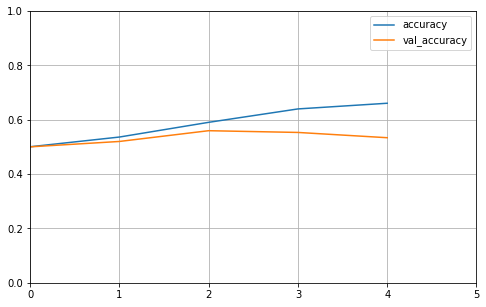

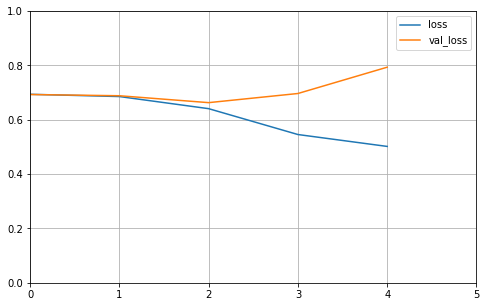

In [14]:


def plot_learning_curves(history,label,epochs,min_value,max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=[8,5])
    plt.grid(True)
    plt.axis([0,epochs,min_value,max_value])
    plt.show()

plot_learning_curves(single_rnn_history,'accuracy',5,0,1)
plot_learning_curves(single_rnn_history,'loss',5,0,1)

In [16]:
single_rnn_model.evaluate(
            test_data, test_labels,
            batch_size = batch_size,
            verbose=2)

25000/1 - 41s - loss: 0.8013 - accuracy: 0.5370


[0.7943046627616882, 0.53696]

In [19]:
# 多层双向循环神经网络
enbedding_dim = 16
batch_size = 128

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, enbedding_dim,))
model.add(keras.layers.Bidirectional(keras.layers.SimpleRNN(units=32,return_sequences=True)))
model.add(keras.layers.Bidirectional(keras.layers.SimpleRNN(units=32,return_sequences=False)))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam',#optimizer优化器
              loss='binary_crossentropy',#由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 binary_crossentropy 损失函数。
              metrics=['accuracy'])#准确率（accuracy）结果会返回一个accuracy



Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 64)          3136      
_________________________________________________________________
bidirectional_4 (Bidirection (None, 64)                6208      
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 170,401
Trainable params: 170,401
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 249s 12ms/sample - loss: 0.6947 - accuracy: 0.5131 - val_loss: 0.6907 - val_accuracy: 0.5244
Epoch 2/10
20000/20000 [==============================] - 248s 12ms/sample - loss: 0.6197 - accuracy: 0.6569 - val_loss: 0.5825 - val_accuracy: 0.7026
Epoch 3/10
20000/20000 [==============================] - 243s 12ms/sample - loss: 0.4460 - accuracy: 0.8022 - val_loss: 0.7208 - val_accuracy: 0.5420
Epoch 4/10
20000/20000 [==============================] - 244s 12ms/sample - loss: 0.3710 - accuracy: 0.8371 - val_loss: 0.4830 - val_accuracy: 0.8040
Epoch 5/10
20000/20000 [==============================] - 249s 12ms/sample - loss: 0.1616 - accuracy: 0.9406 - val_loss: 0.6259 - val_accuracy: 0.7992
Epoch 6/10
20000/20000 [==============================] - 437s 22ms/sample - loss: 0.0897 - accuracy: 0.9682 - val_loss: 0.7610 - val_accuracy: 0.7642
Epoch 7/10
20000/20000 [=====================

In [22]:
loss,acc = model.evaluate(test_data,  test_labels, verbose=2)

print('loss',loss)
print('acc',acc)


25000/1 - 178s - loss: 0.6450 - accuracy: 0.7460
loss 1.2771898666265606
acc 0.74596


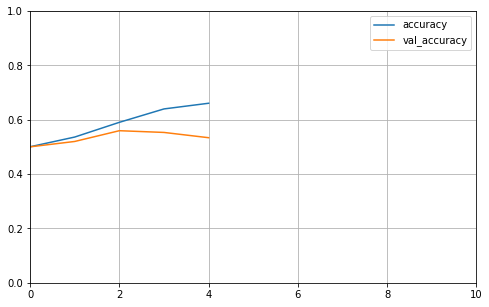

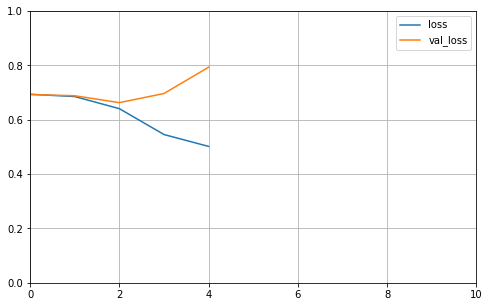

In [24]:
plot_learning_curves(history,'accuracy',10,0,1)
plot_learning_curves(history,'loss',10,0,1)

In [25]:
# 单层双向循环神经网络
enbedding_dim = 16
batch_size = 128

bi_cnn_model = keras.Sequential()
bi_cnn_model.add(keras.layers.Embedding(vocab_size, enbedding_dim,))
bi_cnn_model.add(keras.layers.Bidirectional(keras.layers.SimpleRNN(units=32,return_sequences=False)))
bi_cnn_model.add(keras.layers.Dense(16, activation='relu'))
bi_cnn_model.add(keras.layers.Dense(1, activation='sigmoid'))

bi_cnn_model.summary()

bi_cnn_model.compile(optimizer='adam',#optimizer优化器
              loss='binary_crossentropy',#由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 binary_crossentropy 损失函数。
              metrics=['accuracy'])#准确率（accuracy）结果会返回一个accuracy




Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 16)          160000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)                3136      
_________________________________________________________________
dense_8 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 17        
Total params: 164,193
Trainable params: 164,193
Non-trainable params: 0
_________________________________________________________________


In [26]:
history = bi_cnn_model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 128s 6ms/sample - loss: 0.6930 - accuracy: 0.5149 - val_loss: 0.6970 - val_accuracy: 0.5064
Epoch 2/10
20000/20000 [==============================] - 140s 7ms/sample - loss: 0.6251 - accuracy: 0.6407 - val_loss: 0.5333 - val_accuracy: 0.7504
Epoch 3/10
20000/20000 [==============================] - 148s 7ms/sample - loss: 0.3965 - accuracy: 0.8336 - val_loss: 0.4216 - val_accuracy: 0.8296
Epoch 4/10
20000/20000 [==============================] - 139s 7ms/sample - loss: 0.2516 - accuracy: 0.9044 - val_loss: 0.4251 - val_accuracy: 0.8326
Epoch 5/10
20000/20000 [==============================] - 162s 8ms/sample - loss: 0.1588 - accuracy: 0.9434 - val_loss: 0.5199 - val_accuracy: 0.8138
Epoch 6/10
20000/20000 [==============================] - 138s 7ms/sample - loss: 0.0870 - accuracy: 0.9724 - val_loss: 0.7061 - val_accuracy: 0.7444
Epoch 7/10
20000/20000 [===========================

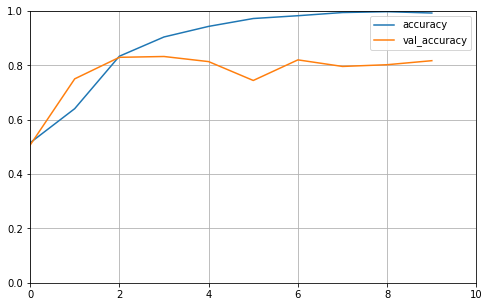

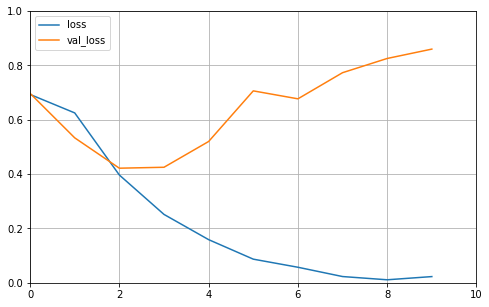

In [27]:
plot_learning_curves(history,'accuracy',10,0,1)
plot_learning_curves(history,'loss',10,0,1)

In [28]:
loss,acc = bi_cnn_model.evaluate(test_data,  test_labels, verbose=2)

print('loss',loss)
print('acc',acc)

25000/1 - 100s - loss: 1.1409 - accuracy: 0.8051
loss 0.9320827589821815
acc 0.80508


In [29]:
#LSTM长短期记忆网络，避免RNN信息不能长久
# 输入形状是用于电影评论的词汇数目（10,000 词）
vocab_size = 10000
enbedding_dim = 16
batch_size = 128

lstm_model = keras.Sequential([
        keras.layers.Embedding(vocab_size, enbedding_dim,input_length = maxlen),
        keras.layers.Bidirectional(keras.layers.LSTM(units=32,return_sequences=False)),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
])

lstm_model.summary()
lstm_model.compile(optimizer='adam',#optimizer优化器
              loss='binary_crossentropy',#由于这是一个二分类问题且模型输出概率值（一个使用 sigmoid 激活函数的单一单元层），我们将使用 binary_crossentropy 损失函数。
              metrics=['accuracy'])#准确率（accuracy）结果会返回一个accuracy

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 256, 16)           160000    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 64)                12544     
_________________________________________________________________
dense_10 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 174,657
Trainable params: 174,657
Non-trainable params: 0
_________________________________________________________________


In [35]:
history = lstm_model.fit(train_data,
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_split=0.2,
                    verbose=1)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 432s 22ms/sample - loss: 0.5569 - accuracy: 0.6882 - val_loss: 0.3936 - val_accuracy: 0.8430
Epoch 2/10
20000/20000 [==============================] - 291s 15ms/sample - loss: 0.2677 - accuracy: 0.8985 - val_loss: 0.3059 - val_accuracy: 0.8728
Epoch 3/10
20000/20000 [==============================] - 280s 14ms/sample - loss: 0.1867 - accuracy: 0.9342 - val_loss: 0.3076 - val_accuracy: 0.8838
Epoch 4/10
20000/20000 [==============================] - 281s 14ms/sample - loss: 0.1423 - accuracy: 0.9512 - val_loss: 0.3642 - val_accuracy: 0.8706
Epoch 5/10
20000/20000 [==============================] - 304s 15ms/sample - loss: 0.1139 - accuracy: 0.9639 - val_loss: 0.4070 - val_accuracy: 0.8726
Epoch 6/10
20000/20000 [==============================] - 279s 14ms/sample - loss: 0.0935 - accuracy: 0.9691 - val_loss: 0.4289 - val_accuracy: 0.8740
Epoch 7/10
20000/20000 [=====================

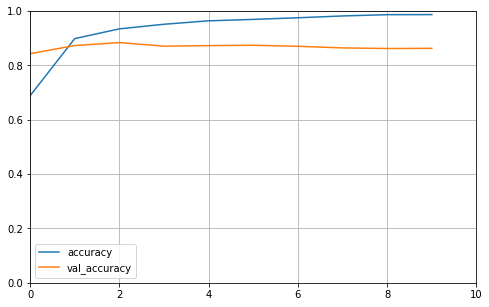

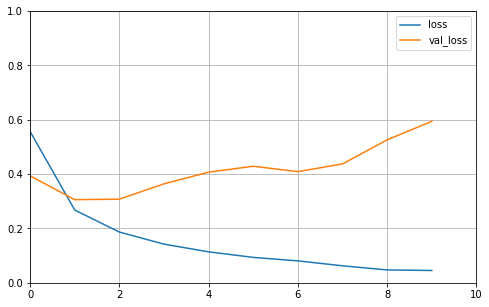

In [36]:
plot_learning_curves(history,'accuracy',10,0,1)
plot_learning_curves(history,'loss',10,0,1)

In [37]:
loss,acc = lstm_model.evaluate(test_data,  test_labels, verbose=2)

print('loss',loss)
print('acc',acc)

25000/1 - 232s - loss: 0.6299 - accuracy: 0.8470
loss 0.6639880334472656
acc 0.84696
